In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import json
import os

from analysis import plot, process # importing analysis module enables import from model folder
import analysis.pipelines.population_spikes as ps

%matplotlib inline

RESULT_PATH = "simulation_results"
OUTPUT_PATH = "analysis_results"
overwrite = False

pop_color = plot.pop_color

savefig = True

In [2]:
ps.set_variables(RESULT_PATH=RESULT_PATH, OUTPUT_PATH=OUTPUT_PATH)

PN_pop_names = ps.PN_pop_names
ITN_pop_names = ps.ITN_pop_names

### Processing parameters

In [3]:
max_lag = 300. # ms. maximum time lag for cross-correlation
method = 'wavelet'  # method to obtain wave amplitude

wave_lines = {'gamma': ':', 'beta': '--'}
waves = list(wave_lines)
# waves = ['gamma']
# waves = ['beta']


wave_kwargs = {
    'filter': dict(
        waves = {'gamma': (30.0, 44.0), 'beta': (14.5, 23.5)},
        transform = process.wave_hilbert,
        filt_order = 4
    ),
    'wavelet': dict(
        waves = {'gamma': 37.0, 'beta': 19.0},
        transform = process.wave_cwt,
        bandwidth = 2.0  # time band (inverse to frequency band), sigma of the gaussian envelope for frequency 1.0
    )
}
wave_kwargs = wave_kwargs[method]

wave_kwargs['waves'] = {w: wave_kwargs['waves'][w] for w in waves}

In [4]:
# filter = ('short', ('rand', 'div'))
# filter = ('long', ('rand', 'div'))
filter = (('short', 'long'), ('rand', 'div'))
exclude = 'baseline'
revert_junction = True

# filter = ('rand', 'div')
# revert_junction = False
# exclude = ['baseline', 'short', 'long']

with open(os.path.join(OUTPUT_PATH, 'trials_ordered.json'), 'r') as f:
    trials_ordered = json.load(f)
trials = ps.get_trials(filter, trials=trials_ordered, revert_junction=revert_junction, exclude=exclude)
print(trials)

['short_rand', 'short_div', 'long_rand', 'long_div']


### Processing

In [5]:
pop_names = ITN_pop_names
pop_names = {'PN': PN_pop_names, **dict(zip(ITN_pop_names, ITN_pop_names))}

amp_pha = {p: [] for p in pop_names}
lfp_waves = []
for trial in trials:
    ap, lw = ps.get_lfp_entrainment(trial, wave_kwargs, pop_names=pop_names, overwrite=overwrite)
    for p, x in zip(pop_names, ap):
        amp_pha[p].append(x)
    lfp_waves.append(lw)

In [6]:
amp_pha = {p: np.concatenate(x, axis=-1) for p, x in amp_pha.items()}
amp_pha = {p: xr.DataArray(x,
        dims=['component', 'wave', 'spike'],
        coords={'component': ['amp', 'pha'], 'wave': list(wave_kwargs['waves'].keys())}
    ) for p, x in amp_pha.items()}

duration = np.sum([da.time[-1] - da.time[0] for da in lfp_waves]) / 1000  # sec
lfp_waves = xr.concat(lfp_waves, dim='time')

In [7]:
pop_ids, info = ps.load_trial(trials[0], pop_names, only_id=True)
pop_num = {p: len(ids) for p, ids in pop_ids.items()}

### Distribution of LFP waves amplitude and phase at spike times

In [8]:
nbins_amp = 16
nbins_pha = 16

quantiles = np.linspace(0, 1, nbins_amp + 1)
lfp_amp = lfp_waves.sel(component='amp')
axis = lfp_amp.dims.index('time')
amp_bins = np.moveaxis(np.quantile(lfp_amp.values, quantiles, axis=axis), 0, axis)
amp_bins = xr.DataArray(amp_bins, coords={'wave': lfp_amp.wave, 'quantile': quantiles})
pha_bins = np.linspace(-np.pi, np.pi, nbins_pha + 1)

In [9]:
waves = lfp_waves.wave.values
n_waves = len(waves)
n_pop = len(pop_names)

fr_hist = np.zeros((n_pop, n_waves, nbins_pha, nbins_amp))

for i, p in enumerate(pop_names):
    for j, w in enumerate(waves):
        ap = amp_pha[p].sel(wave=w)
        fr, _, _ = np.histogram2d(ap.sel(component='pha'), ap.sel(component='amp'), bins=(pha_bins, amp_bins.sel(wave=w)))
        fr /= pop_num[p] * duration
        fr_mean = fr.mean()
        fr_hist[i, j] = 100 * (fr - fr_mean) / fr_mean

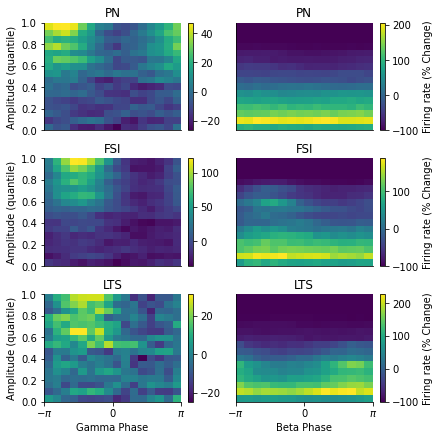

In [16]:
common_clim = False
figsize = (3, 2)

fig, axs = plt.subplots(n_pop, n_waves, figsize=(figsize[0] * n_waves, figsize[1] * n_pop),
                        squeeze=False, constrained_layout=True)
for i, p in enumerate(pop_names):
    if common_clim:
        vmin, vmax = fr_hist[i].min(), fr_hist[i].max()
    else:
        vmin, vmax = None, None
    for j, w in enumerate(waves):
        ax = axs[i, j]
        pcm = ax.pcolormesh(pha_bins, quantiles, fr_hist[i, j].T, vmin=vmin, vmax=vmax)
        ax.set_title(p)
        if i < n_pop - 1:
            ax.get_xaxis().set_visible(False)
        else:
            ax.set_xlabel(w.title() + ' Phase')
            ax.set_xticks((-np.pi, 0, np.pi))
            ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
        if j > 0:
            ax.get_yaxis().set_visible(False)
        else:
            ax.set_ylabel('Amplitude (quantile)')
        if not common_clim:
            plt.colorbar(mappable=pcm, ax=ax, label='Firing rate (% Change)' if j == n_waves - 1 else None, pad=0.02)
    if common_clim:
        plt.colorbar(mappable=pcm, ax=axs[i], label='Firing rate (% Change)', pad=0.02)
plt.show()

In [11]:
if savefig:
    plot.savefig(fig, 'Fig2_F')

### Count for gamma in short and beta in long separately

In [12]:
short_file = os.path.join(ps.ENTR_PATH, 'short_gamma.npy')
long_file = os.path.join(ps.ENTR_PATH, 'long_beta.npy')

# np.save(short_file, fr_hist)
# np.save(long_file, fr_hist)

In [13]:
fr_hist = np.concatenate((np.load(short_file), np.load(long_file)), axis=1)

pop_names = {'PN': PN_pop_names, **dict(zip(ITN_pop_names, ITN_pop_names))}
waves = list(wave_lines)
n_waves = len(waves)
n_pop = len(pop_names)

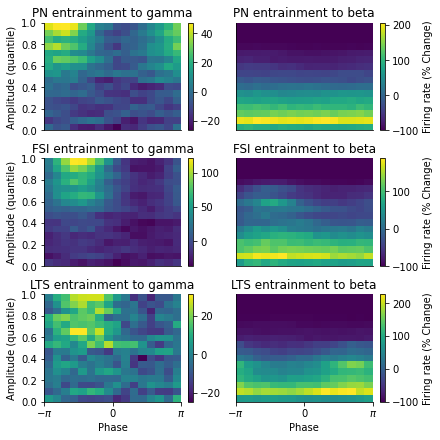

In [14]:
common_clim = False

_, axs = plt.subplots(n_pop, n_waves, figsize=(figsize[0] * n_waves, figsize[1] * n_pop),
                      squeeze=False, constrained_layout=True)
for i, p in enumerate(pop_names):
    if common_clim:
        vmin, vmax = fr_hist[i].min(), fr_hist[i].max()
    else:
        vmin, vmax = None, None
    for j, w in enumerate(waves):
        ax = axs[i, j]
        pcm = ax.pcolormesh(pha_bins, quantiles, fr_hist[i, j].T, vmin=vmin, vmax=vmax)
        ax.set_title(f'{p} entrainment to {w}')
        if i < n_pop - 1:
            ax.get_xaxis().set_visible(False)
        else:
            ax.set_xlabel('Phase')
            ax.set_xticks((-np.pi, 0, np.pi))
            ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
        if j > 0:
            ax.get_yaxis().set_visible(False)
        else:
            ax.set_ylabel('Amplitude (quantile)')
        if not common_clim:
            plt.colorbar(mappable=pcm, ax=ax, label='Firing rate (% Change)' if j == n_waves - 1 else None, pad=0.02)
    if common_clim:
        plt.colorbar(mappable=pcm, ax=axs[i], label='Firing rate (% Change)', pad=0.02)
plt.show()